# Forecasting Stock Perfomance with Prophet

<p><img src="https://picsum.photos/1200/200/?image=357" class="img-fluid" alt="Responsive image" /></p>

In this post we will be using [Prophet](https://facebook.github.io/prophet/) to forecast time series data.  The data we will be using is historical daily SA&P 500 adjusted close price.  We will first create a 3 year forecast usind ytd data and then simulate historical monthly forecasts dating back to 1980.   Finally we will create various trading strategies to attempt to beat the tried and true method of buying and holding.

Sections:
* [Imports](#Imports)
* [Data Preparation](#Data-Preparation)
* [Prophet](#Prophet)
* [Simulating Forecasts](#Simulating-Forecasts)
* [Trading Algorithms](#Trading-Algorithms)
* [Summary](#Summary)

## Imports

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
 
plt.style.use('seaborn-deep')
pd.options.display.float_format = "{:,.2f}".format

To forecast and manipulate time series data, this code imports necessary libraries.

Using pandas as a library, the first line of code imports it. Python's Pandas library is a popular data analysis and manipulation tool. Numpy library is imported as np in the second line. The NumPy library is a powerful tool for scientific computation and working with arrays.

Thirdly, Prophet is imported from the Facebook Prophet package. The Prophet library is an open-source library developed by Facebook to forecast time series.

Matplotlib's pyplot module and functools' reduce method are imported for displaying data and applying functions cumulatively.

To display matplotlib plots in output cells of Jupyter Notebook, the next line uses the %matplotlib inline command.

Plots are styled and float values are formatted in the last three lines of code. To give the plots a dark background and deep colors, the seaborn-deep style is set using plt.style.use(). A float value in a pandas dataframe will have two decimal places if pd.options.display.float_format is set to two. Last but not least, warnings.filterwarnings('ignore') suppresses any warnings generated during program execution.

For this project we will be importing the standard libraries for data anaysis with Python.  We will also import Prophet and reduce from functools which will be used to help simulate our Forecasts.

## The Data

In [2]:
stock_price =  pd.read_csv('^GSPC.csv',parse_dates=['Date'])

In this code, we read data from a CSV file named GSPC.csv into a pandas dataframe called stock_price using the pandas library. pd.read_csv() returns a dataframe from a CSV file.

Pandas interprets the 'Date' column as a date and time data type when parse_dates is set to ['Date']. Time series analysis benefits from this because it makes it easier to work with the time component.

With each row representing a day in the stock market, the resulting dataframe contains the data from the CSV file. Date, Open, High, Low, Close, Adjust Close, and Volume are the columns of the dataframe. For each day, these columns contain information about the opening price, high price, low price, closing price, adjusted closing price, and volume of trading.

In [3]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9885 entries, 0 to 9884
Data columns (total 7 columns):
Date         9885 non-null datetime64[ns]
Open         9885 non-null float64
High         9885 non-null float64
Low          9885 non-null float64
Close        9885 non-null float64
Adj Close    9885 non-null float64
Volume       9885 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 540.7 KB


Stock_price.info() displays a summary of each column in the DataFrame stock_price, including its data types, non-null values, and memory usage.

The output is: 

Stock_price is a pandas DataFrame object with 9885 rows and 7 columns, as shown by stock_price.info().

Each column in the DataFrame is summarized in the Data columns section of the output:

Stock prices are recorded using a column of datetime values.

On each corresponding date, these columns contain float values representing the stock market's opening, highest, lowest, closing, and adjusted closing prices.

The volume of the stock market on each date is represented by a column of integer values.

Each column in the DataFrame is listed by its data type in the dtypes section. Date columns have the datetime64[ns] data type, which indicates they contain datetime values. A float64 data type indicates that the Open, High, Low, Close, and Adj Close columns contain floating-point values. There are integer values in the Volume column because it has the int64 data type.

In the memory usage section, you can see how much memory the DataFrame uses in kilobytes (KB). Currently, 540.7 KB of memory is being used by the DataFrame.

As a result, this output provides useful information about the structure and content of the stock_price DataFrame. It confirms that all columns have the expected data types and that there are no missing values in the DataFrame.

In [4]:
stock_price.describe()

Open     High      Low    Close  Adj Close            Volume
count 9,885.00 9,885.00 9,885.00 9,885.00   9,885.00          9,885.00
mean    958.64   964.26   952.65   958.86     958.86  1,628,930,637.33
std     696.19   699.39   692.67   696.24     696.24  1,765,031,087.55
min      98.22    99.58    94.23    98.22      98.22     14,990,000.00
25%     326.24   328.00   322.98   326.35     326.35    169,010,000.00
50%     955.40   965.38   949.45   955.41     955.41    805,900,000.00
75%   1,347.74 1,355.87 1,336.36 1,347.74   1,347.74  3,150,330,000.00
max   2,936.76 2,940.91 2,927.11 2,930.75   2,930.75 11,456,230,000.00

As a pandas DataFrame method, stock_price.describe() summarizes the numerical columns in the stock_price DataFrame.

As a result of running this code, here is the output:

count: The number of non-null values in each column.

mean: The arithmetic mean of each column.

std: The standard deviation of each column.

min: The minimum value of each column.

25%: The first quartile value of each column, i.e., the value below which 25% of the observations fall.

50%: The median value of each column, i.e., the value below which 50% of the observations fall.

75%: The third quartile value of each column, i.e., the value below which 75% of the observations fall.

max: The maximum value of each column.

For example, the output shows that the Open column has a count of 9,885, a mean value of 958.64, and a standard deviation of 696.19. This column has a minimum value of 98.22 and a maximum value of 2,936.76. Approximately 326.24 is the 25th percentile, 955.40 is the 50th percentile, and 1,347.74 is the 75th percentile.

The stock_price.describe() function provides a useful summary of the distribution of values in the numerical columns of the DataFrame. In this way, you can understand the range and variability of stock prices and volume over the entire period covered by the DataFrame.

The data we are using is the historical S&P500 prices dating back to 1980.  You can find the data [here](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC).

## Data Preparation

In [5]:
stock_price = stock_price[['Date','Adj Close']]

A subset of columns is selected from the stock_price dataframe using this code. In particular, it selects the columns 'Date' and 'Adj Close', which contain the date and adjusted closing price of the stock market each day.

There are only two columns in the resulting dataframe, "Date" and "Adj Close," and the number of rows remains the same as in the original dataframe. As we can focus on the trend of the adjusted closing price over time, this subset of data is useful for time series analysis and forecasting.

In [6]:
stock_price.columns = ['ds', 'y']
stock_price.head(10)

ds      y
0 1980-01-02 105.76
1 1980-01-03 105.22
2 1980-01-04 106.52
3 1980-01-07 106.81
4 1980-01-08 108.95
5 1980-01-09 109.05
6 1980-01-10 109.89
7 1980-01-11 109.92
8 1980-01-14 110.38
9 1980-01-15 111.14

The stock_price DataFrame is renamed and the first 10 rows of the updated DataFrame are displayed.

Each part of the code does the following:

Stock_price.columns = ['ds', 'y']: Renames the stock_price DataFrame column labels to ds and y. Column names are assigned to the DataFrame's columns attribute using its columns attribute.

This function displays the first 10 rows of the updated stock_price DataFrame.

This code updates the column labels of the stock_price DataFrame to match the Prophet time-series forecasting model's expected input format. Specifically, ds is the column that should contain the time series dates as a pandas datetime object, and y is the column that should contain the forecasted values. To verify that the column labels have been updated correctly, and to inspect the first few rows of the updated DataFrame, we use the head() method.

For prophet to work, we need to change the names of the 'Date' and 'Adj Close' columns to 'ds' and 'y'.  The term 'y' is typically used for the target column (what you are trying to predict) in most machine learning projects.

## Prophet

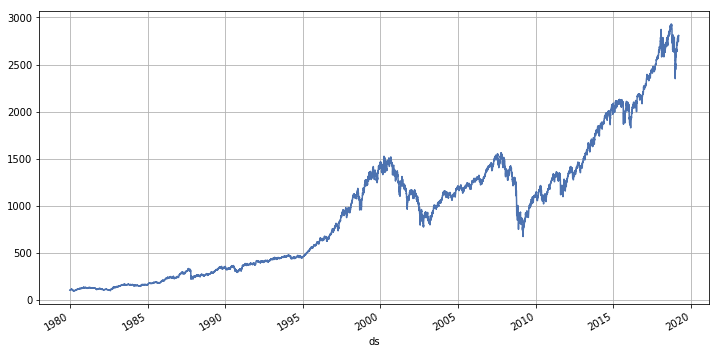

In [7]:
stock_price.set_index('ds').y.plot(figsize=(12,6), grid=True);

In this code, stock_price.set_index('ds').y.plot(figsize=(12,6), grid=True); plots the historical value of the S&P 500 index as a line plot.

A DataFrame is first set up with the index set as 'ds' by calling the set_index() method with the ds argument. DataFrames are created by using dates as their indexes.

A line plot of the time series is generated by calling the plot() method on the y column of the updated DataFrame. This plot is 12 inches wide by 6 inches tall because the figsize parameter is set to (12,6). Grid parameter is set to True, which adds a grid to the plot for easier visualization.

Finally, the semicolon ; suppresses any text output generated by the plot() method, allowing the plot to stand alone.

As a result, this line plot can help identify trends and patterns in the S&P 500 index over time, such as seasonality, cyclical fluctuations, or long-term growth or decline. It is easy to see how the value of the index changes over time when the x-axis shows the date and the y-axis shows the value of the index.



Before we use Prophet to create a forecast let's visualize our data.  It's always a good idea to create a few visualitions to gain a better understanding of the data you are working with.

In [8]:
model = Prophet()
model.fit(stock_price)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In this code, a new instance of the Prophet class is created and the time series data from the stock_price DataFrame is fitted to the model.

Each part of the code does the following:

Creates an instance of the Prophet class, which is a Facebook-developed time-series forecasting model. Prophet uses a generalized additive model approach to capture both linear and non-linear trends in the data, as well as seasonality and holiday effects.

The stock_price DataFrame is fitted to the Prophet model using the fit() method by model.fit(stock_price). Using historical data, the model is trained to predict future data.

A new Prophet model is created and fitted to the stock_price DataFrame, which enables the model to learn from historical data and forecast future prices.

To activate the Prophet Model we simply call `Prophet()` and assign it to a variabl called `model`. Next fit our stock data to the model by calling the `fit` method.

In [9]:
future = model.make_future_dataframe(1095, freq='d')

future_boolean = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[future_boolean] 

future.tail()

ds
10973 2022-03-07
10974 2022-03-08
10975 2022-03-09
10976 2022-03-10
10977 2022-03-11

The code future = model.make_future_dataframe(1095, freq='d'); future_boolean = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) otherwise False); future = future[future_boolean]; future.tail() creates a new pandas DataFrame called future that contains a range of future dates for which the Prophet model will make predictions.

First, the make_future_dataframe() method is invoked on the Prophet model object with the arguments 1095, which specifies the number of days to forecast, and freq='d', which specifies the frequency of the dates.

Following that, the dates in future are filtered to include only weekdays using a Boolean array called future_boolean. On the ds column of the future DataFrame, the map() method is called to create a new array containing True for weekdays (days with a weekday index between 0 and 4 inclusive) and False for weekends (days with a weekday index between 5 and 6 inclusive).

By removing all weekends from the DataFrame, the filtered future DataFrame includes only rows where future_boolean is True.

A final call to tail() on the filtered future DataFrame displays the last few rows, which contain the predictions made by the Prophet model for the future weekdays.

A new DataFrame called future is created, containing a range of future dates for which the Prophet model will predict. Using the code, the model will only make predictions for days when the stock market is open by filtering the dates to include only weekdays.

To create a forecast with our model we need to create some futue dates.  Prophet provides us with a helper function called `make_future_dataframe`.  We pass in the number of future periods and frequency.  Above we created a forecast for the next 1095 days or 3 years.

Since stocks can only be traded on weekdays we need to remove the weekends from our forecast dataframe.  To do so we create a boolean expression where if a day does not equal 0 - 4 then return False.  "0 = Monday, 6=Saturday, etc.."

We then pass the boolean expression to our dataframe with returns only True values.  We now have a forecast dataframe comprised of the next 3 years of weekdays.

In [10]:
forecast = model.predict(future)

By fitting the Prophet model to the historical data in the stock_price DataFrame, this code forecasts the future dates contained in the future DataFrame.

This code does the following:

Using the Prophet model fitted to the historical data in the stock_price DataFrame, forecast = model.predict(future): Generates a forecast for the future dates in the future DataFrame. When the predict() method is called on the Prophet model object, the argument future specifies the DataFrame containing the future dates for which the model should generate predictions.

There are columns for yhat (the forecast value), yhat_lower (the lower bound of the predicted interval), and yhat_upper (the upper bound of the predicted interval) for each date in the forecast DataFrame. During the fitting process, the Prophet model identified columns that represent trend, seasonality, and holidays.

Based on the historical stock price data in the stock_price DataFrame, this code forecasts future dates using the Prophet model. Based on the forecast DataFrame, the S&P 500 index can be analyzed over time in terms of predicted values and intervals.

In [11]:
forecast.tail()

ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
10661 2022-03-07 3,398.27    3,043.92    3,765.33     3,050.21     3,757.76   
10662 2022-03-08 3,398.82    3,035.27    3,784.78     3,049.62     3,758.73   
10663 2022-03-09 3,399.38    3,044.68    3,769.69     3,049.04     3,759.69   
10664 2022-03-10 3,399.93    3,034.44    3,796.22     3,048.49     3,760.65   
10665 2022-03-11 3,400.49    3,040.25    3,798.08     3,047.96     3,761.62   

       additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
10661            0.46                  0.46                  0.46    0.90   
10662            1.09                  1.09                  1.09    1.40   
10663            1.25                  1.25                  1.25    1.37   
10664            1.43                  1.43                  1.43    1.32   
10665            1.48                  1.48                  1.48    1.11   

       weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
10661          0.90          0.90   -0.44         -0.44         -0.44   
10662          1.40          1.40   -0.30         -0.30         -0.30   
10663          1.37          1.37   -0.12         -0.12         -0.12   
10664          1.32          1.32    0.10          0.10          0.10   
10665          1.11          1.11    0.37          0.37          0.37   

       multiplicative_terms  multiplicative_terms_lower  \
10661                  0.00                        0.00   
10662                  0.00                        0.00   
10663                  0.00                        0.00   
10664                  0.00                        0.00   
10665                  0.00                        0.00   

       multiplicative_terms_upper     yhat  
10661                        0.00 3,398.73  
10662                        0.00 3,399.92  
10663                        0.00 3,400.63  
10664                        0.00 3,401.36  
10665                        0.00 3,401.97

Code that displays predicted S&P 500 index values for future dates contained in the future DataFrame for the last few rows of the forecast DataFrame.

This code does the following:

This function displays the last few rows of the forecast DataFrame containing the predicted values for the S&P 500 index for the future dates contained in the future DataFrame. A forecast DataFrame calls the tail() method, which displays the last 5 rows by default.

This output shows the predicted values for yhat (forecasted value), yhat_lower (lower bound of predicted interval), and yhat_upper (upper bound of predicted interval) for each future date. During the fitting process, the Prophet model identified columns that represent trend, seasonality, and holidays.

Using this code, we can analyze trends and patterns in predicted values over time for the S&P 500 index for the future dates in the future DataFrame.

To create the forecast we call `predict` from our `model` and pass in the `future` dataframe we created earlier.  We return the results in a new dataframe called `forecast`.  

When we inspect the `forecast` dataframe we see a bunch of new terms.  The one we are most interested in is `yhat` which is our forecasted value.

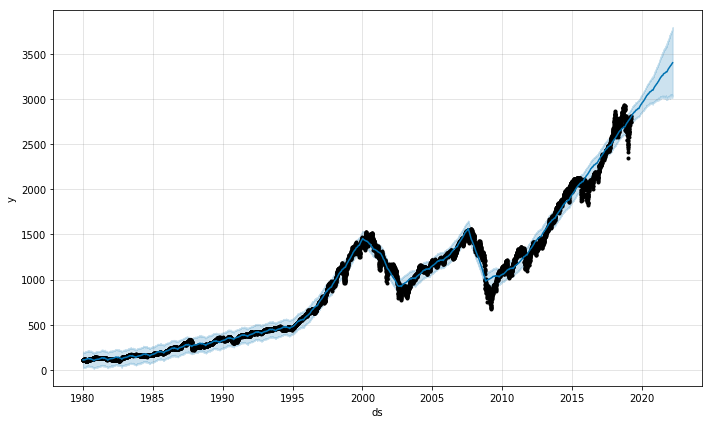

In [12]:
model.plot(forecast);

It shows a plot of the forecast DataFrame, together with the historical data from the stock_price DataFrame used to fit the Prophet model, as well as predicted values for the S&P 500 index over time.

Using this code, you can:

This method generates a plot of the forecast DataFrame, showing the predicted values for the S&P 500 index over time along with the historical data from the stock_price DataFrame that was used to fit the Prophet model. A DataFrame with predicted values is specified with the argument forecast to the plot() method on the Prophet model object.

As a result, a black line shows historical stock price data, and a blue line shows predicted S&P 500 values. Around the blue line, the shaded blue area represents the uncertainty intervals for the predicted values, with the light blue area representing the 80% confidence interval and the dark blue area representing the 95% confidence interval. During the fitting process, the Prophet model also identified trend, seasonality, and holiday components.

We can visualize the trends and patterns in the predicted values by comparing them to the historical values using this code, which generates a plot of the predicted values for the S&P 500 index over time.

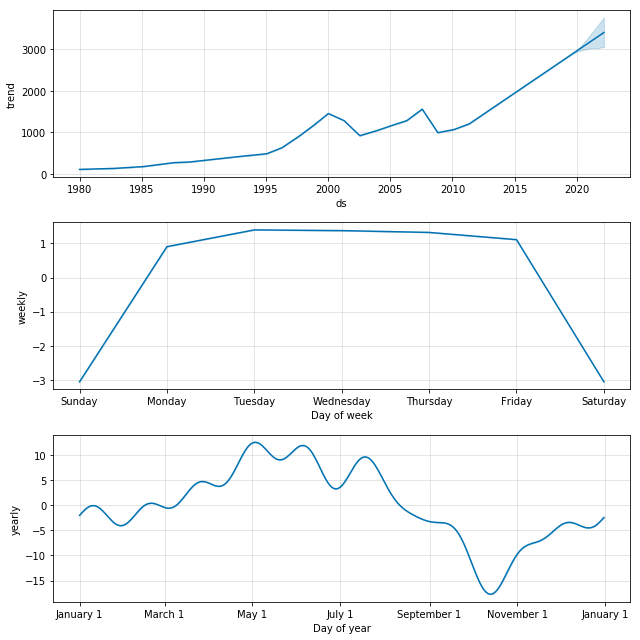

In [13]:
model.plot_components(forecast);

Based on the predicted values contained in the forecast DataFrame, this code generates plots showing trend, seasonality, and holiday components of the Prophet model.

Using this code, you can:

Based on prediction values contained in the forecast DataFrame, model.plot_components(forecast) generates a set of plots showing trend, seasonality, and holiday components. Prophet model objects are passed forecast as the argument to plot_components(), which returns a DataFrame containing predicted values.

A black line represents the trend component of the model, while a blue line represents the seasonality component. A plot of the yearly and weekly seasonality components is shown in the first plot. Monthly seasonality is shown in the second plot, while daily seasonality is shown in the third plot. With each holiday represented as a separate line in the fourth plot, we can see how holidays affect predicted values.

Based on the predicted values contained in the forecast DataFrame, this code generates a set of plots that visualize the trend, seasonality, and holiday components of the Prophet model. We can use this information to better understand the factors that drive the predicted values of the S&P 500 index over time.

All the new fields appear a bit daunting but fortunately Prophet comes with two handy visualization helpers, `plot` and `plot_components`.  The `plot` functions creates a graph of our actuals and forecast and `plot_components` provides us a graph of our trend and seasonality.

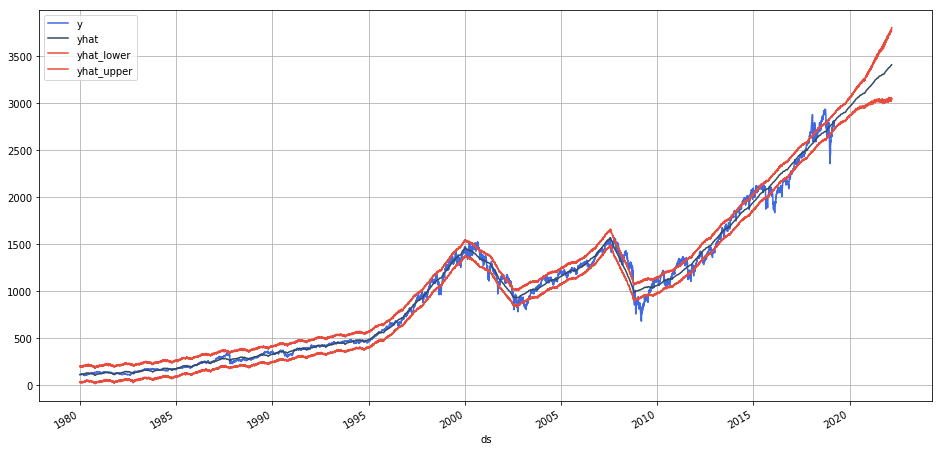

In [14]:
stock_price_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df = pd.merge(stock_price, stock_price_forecast, on='ds', how='right')
df.set_index('ds').plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True);

This code creates a new DataFrame called df that combines the historical data from the stock_price DataFrame with the predicted values from the forecast DataFrame, and then generates a line plot of the historical and predicted values over time.

Here's what this code does:

stock_price_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]: Creates a new DataFrame called stock_price_forecast that contains the predicted values for the S&P 500 index, extracted from the forecast DataFrame. This DataFrame contains columns for the ds (date) column, as well as the yhat (forecasted value), yhat_lower (lower bound of the predicted interval), and yhat_upper (upper bound of the predicted interval) columns.
df = pd.merge(stock_price, stock_price_forecast, on='ds', how='right'): Merges the historical data from the stock_price DataFrame with the predicted values from the stock_price_forecast DataFrame, using the ds (date) column as the key. The resulting df DataFrame contains columns for the ds (date), y (actual historical value), yhat (forecasted value), yhat_lower (lower bound of the predicted interval), and yhat_upper (upper bound of the predicted interval).
df.set_index('ds').plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True): Generates a line plot of the historical and predicted values over time, using the df DataFrame. The set_index() method is called on the df DataFrame to set the ds (date) column as the index. The plot() method is then called on the resulting DataFrame, with the argument figsize=(16,8) specifying the size of the plot, and the argument color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"] specifying the colors of the lines for the historical data, forecasted values, and uncertainty intervals. The argument grid=True adds a grid to the plot for easier visualization.
The resulting plot shows the historical data from the stock_price DataFrame as a blue line, with the predicted values for the S&P 500 index shown as a red line. The shaded red area around the red line represents the uncertainty intervals for the predicted values, with the lighter red area representing the 80% confidence interval and the darker red area representing the 95% confidence interval. The plot allows us to visualize how well the Prophet model fits the historical data, as well as how well it predicts the future values of the S&P 500 index.

The visualization helpers are just using the data in our `forecast` dataframe.  We can actually recreate the same graphs.  Above I recreated the `plot` graph.

## Simulating Forecasts

Our 3-year forecast is pretty cool, but we want to backtest it and develop a trading strategy before making any trading decisions.


This section simulates Prophet's existence back in 1980 and uses it to create a monthly forecast through 2019. The following section will simulate how various trading strategies performed compared to buying and holding a stock.

In [15]:
stock_price['dayname'] = stock_price['ds'].dt.day_name()
stock_price['month'] = stock_price['ds'].dt.month
stock_price['year'] = stock_price['ds'].dt.year
stock_price['month/year'] = stock_price['month'].map(str) + '/' + stock_price['year'].map(str) 

stock_price = pd.merge(stock_price, 
                       stock_price['month/year'].drop_duplicates().reset_index(drop=True).reset_index(),
                       on='month/year',
                       how='left')

stock_price = stock_price.rename(columns={'index':'month/year_index'})

As part of this code, we add four new columns to the stock_price DataFrame that contain information about the date in the ds column.

In the stock_price DataFrame, the first line creates a column called dayname that contains the day of the week (e.g., Monday, Tuesday) corresponding to each date in the ds column. Datetime properties are accessed using the .dt attribute, and the day_name() method returns the day name.

A new column, month, is created in the stock_price DataFrame to store the month of each date in the ds column (as a number between 1 and 12). Datetime objects can be accessed by their month value using the dt attribute.

In the stock_price DataFrame, the third line creates a new column called year that contains the year corresponding to each date. This time, the datetime object's year value can be accessed using the dt attribute.

With the fourth line, the month and year columns are concatenated as strings in the stock_price DataFrame, separated by a forward slash (/). DataFrames created this way have unique identifiers for each month/year combination.

A single row is created for each unique month/year combination in the stock_price DataFrame with the help of the pd.merge() function in the fifth line. Each unique month/year combination is indexed by its unique integer index in the resulting DataFrame, which has an additional column called index.

As a final step, the dataframe's index column is renamed to month/year_index in order to be more clear about the fact that this column contains unique integer indexes for each unique combination of month and year.

In [16]:
stock_price.tail()

ds        y    dayname  month  year month/year  month/year_index
9880 2019-03-08 2,743.07     Friday      3  2019     3/2019               470
9881 2019-03-11 2,783.30     Monday      3  2019     3/2019               470
9882 2019-03-12 2,791.52    Tuesday      3  2019     3/2019               470
9883 2019-03-13 2,810.92  Wednesday      3  2019     3/2019               470
9884 2019-03-14 2,808.48   Thursday      3  2019     3/2019               470

As a result of the stock_price.tail() method, the last five rows of the stock_price DataFrame are displayed. In this way, the previous transformations can be checked and verified quickly.

As a result of the tail() function, we receive the last five rows of the stock_price DataFrame, containing the columns ds (date), y (adjusted closing price), dayname, month, year, month/year, and month/year_index.

Tail() can be used to check whether the new columns were correctly added to the DataFrame and whether the data is sorted in the right order by date. Furthermore, the output can provide insight into the overall structure and patterns of the data, such as gaps or outliers.

Generally, the tail() function is useful for verifying that any previous transformations have been applied correctly.

Before we simulate the monthly forecasts we need to add some columns to our `stock_price` dataframe we created in the beginning of this project to make it a bit easier to work with.  We add month, year, month/year, and month/year_index. 

In [ ]:
loop_list = stock_price['month/year'].unique().tolist()
max_num = len(loop_list) - 1
forecast_frames = []

for num, item in enumerate(loop_list):

    if  num == max_num:
        pass
    else:
        df = stock_price.set_index('ds')[
             stock_price[stock_price['month/year'] == loop_list[0]]['ds'].min():\
             stock_price[stock_price['month/year'] == item]['ds'].max()]
        
        df = df.reset_index()[['ds', 'y']]
        
        model = Prophet()
        model.fit(df)
        
        future = stock_price[stock_price['month/year_index'] == (num + 1)][['ds']]

        forecast = model.predict(future)
        forecast_frames.append(forecast)

Using Python, this code forecasts stock prices over time using a time series model. By using the tolist() method, the first line of code creates a unique list of month/year values from a column in the stock_price dataset.

Using the loop_list list as a source, the following line creates a variable named max_num. A for loop will be used later on to use this information. Using the third line, the stock price predictions are stored in an empty list called forecast_frames.

Iterating through the items in loop_list is then performed using a for loop. As a result of the enumerate() method, a tuple contains both the item's index and its value. As well as keeping track of the current index number (num), this code also keeps track of the current item (item).

Inside the for loop, an if statement checks whether the current index is equal to max_num. The loop will move on to the next item if the pass statement is executed. The code inside the else block is executed if the current index is less than max_num.

As a first step, the else block creates a new dataset called df, which is a subset of the stock_price dataset. For each item in loop_list, the earliest and latest dates are determined by using the min() and max() methods by setting the 'ds' column as the index. Next, only the columns 'ds' and 'y' are included in the resulting dataframe, which is reset to the default index.

After that, a new Prophet model is created and fitted to the df dataframe using the fit() method. In Prophet, a curve is fitted to the data and predictions are made using a Bayesian approach.

In the next step, a new dataframe called future is created containing only the dates for the next item in loop_list. After making a prediction for each date in the future dataframe, it uses the predict() method of the Prophet model. Forecast_frames is then updated with the resulting forecast.

In general, this code fits a curve to a stock price dataset and makes predictions for future time periods by using the Prophet library. Using a list of unique month/year values, it creates a subset of the dataset for each month/year, fits a model to that subset, and uses the model to make predictions for the next time period. For further analysis, forecasts are stored in a list.

In [ ]:
stock_price_forecast = reduce(lambda top, bottom: pd.concat([top, bottom], sort=False), forecast_frames)
stock_price_forecast = stock_price_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
stock_price_forecast.to_csv('stock_price_forecast.csv', index=False)

This code creates a new dataframe called stock_price_forecast after making predictions using the Prophet model for each future time period and storing them in the forecast_frames list.

The reduce() function is used to concatenate all the dataframes in the forecast_frames list into a single dataframe. The lambda function passed to reduce() takes two arguments, top and bottom, and concatenates them using the concat() method of pandas library. The sort=False parameter is used to avoid sorting the resulting dataframe.

Following that, we select only the 'ds', 'yhat', 'yhat_lower', and 'yhat_upper' columns from stock_price_forecast using double brackets. Each of these columns corresponds to a date, predicted price, and upper and lower bounds of the prediction interval.

Finally, the stock_price_forecast dataframe is written to a CSV file named 'stock_price_forecast.csv' without including the default index column. Afterward, this file can be analyzed or visualized further.

We are looping through each unique month/year in the stock_price and fitting the Prophet model to the stock data available to that period, and then forecasting one month ahead. This process continues until we reach the last unique `month/year`. The forecasts are compiled into one dataframe called `stock_price_forecast`. Whenever I need to reset, I can pull the csv file instead of running the model again because it takes a while to run.

In [17]:
stock_price_forecast = pd.read_csv('stock_price_forecast.csv', parse_dates=['ds'])

In the previous step of the time series forecasting process, the 'stock_price_forecast.csv' file was created. A new dataframe called stock_price_forecast is created using the read_csv() method from the pandas library.

In CSV files, the 'ds' column contains dates that need to be parsed and converted into datetime format using the parse_dates parameter. In this way, the date column is treated as a time series data type, which is necessary for further analysis and plotting.

Using the CSV file and parsing the dates, the resulting dataframe can be used for further analysis and visualization of the time series forecast. Data trends and patterns can be identified by plotting the predicted values and prediction intervals over time, for example.

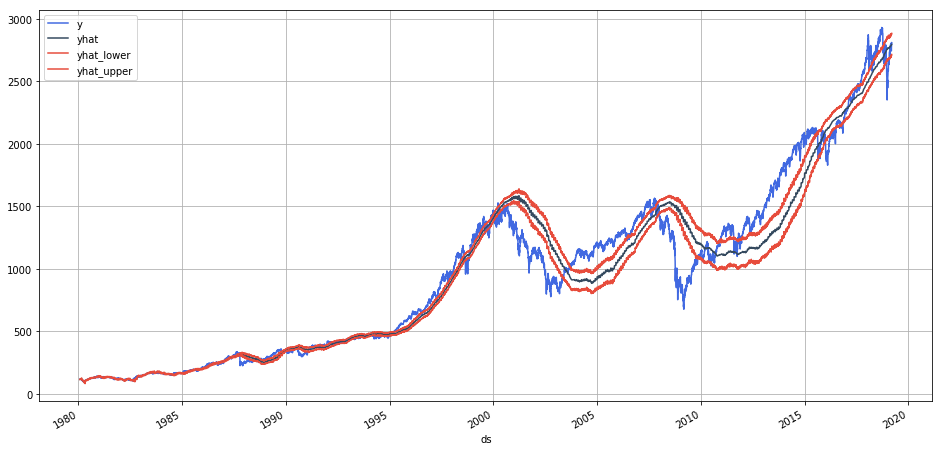

In [18]:
df = pd.merge(stock_price[['ds','y', 'month/year_index']], stock_price_forecast, on='ds')
df['Percent Change'] = df['y'].pct_change()
df.set_index('ds')[['y', 'yhat', 'yhat_lower', 'yhat_upper']].plot(figsize=(16,8), color=['royalblue', "#34495e", "#e74c3c", "#e74c3c"], grid=True)

The code compares actual stock prices with predicted values by merging two dataframes, stock_price and stock_price_forecast.

In the first line of the code, the merge() method from the pandas library is used to create a new dataframe called df. The stock_price dataframe is merged with the stock_price_forecast dataframe, which contains predicted values and prediction intervals. Date information is contained in the 'ds' column, which is merged.

It contains the 'ds' column, the actual stock price ('y'), the month/year index ('month/year_index'), and the predicted values and intervals ('yhat', 'yhat_lower', and 'yhat_upper').

A new column called 'Percent Change' is created in the df dataframe by the second line of code. The 'y' column represents the actual stock prices, and this column calculates the percentage change between the current and previous values. By comparing the percentage change to the predictions made by the model, we can analyze the trend in stock prices.

A new dataframe is created by selecting only the 'y', 'yhat', 'yhat_lower', and 'yhat_upper' columns from the df dataframe, and setting the index to the 'ds' column. The plot() method of pandas is used to create a larger figure by setting figsize to (16,8).

Stock prices and predicted values and intervals are colored according to the color parameter. Royal blue represents actual stock prices, while red represents predicted values and intervals. A grid is added to the plot by setting the grid parameter to True.

As a result of this code, stock prices are merged, the percentage change between consecutive actual prices is calculated, and plotted on a graph so that trends and patterns can be visually compared.

In [19]:
df.head()

ds      y  month/year_index   yhat  yhat_lower  yhat_upper  \
0 1980-02-01 115.12                 1 115.23      114.60      115.85   
1 1980-02-04 114.37                 1 115.74      115.12      116.46   
2 1980-02-05 114.66                 1 116.05      115.38      116.75   
3 1980-02-06 115.72                 1 116.79      116.15      117.50   
4 1980-02-07 116.28                 1 116.50      115.79      117.23   

   Percent Change  
0             nan  
1           -0.01  
2            0.00  
3            0.01  
4            0.00

In this code, we are printing out the first few rows of the dataframe 'df'. When no argument is passed to the head() method of the pandas library, the method returns the first n rows of a dataframe.

The first five rows of the merged dataframe are displayed in the output by calling df.head() in this code. Ensure that the merge operation was successful and that the dataframe contains the expected columns and values by viewing a quick preview of the data.

A dataframe's structure and contents can be quickly inspected using the head() method in data analysis and exploration. Data errors, such as missing values or incorrect data types, should be identified before further analysis or visualization is performed.

Lastly, we determine a Percent Change column by combining our forecast with the actual prices. This column will be used in our Trading Algorithms below. Finally, I plot the forecasts against the actuals to see how it performed. There is a slight delay as you can see. Similar to moving averages, it behaves in similar ways.

## Trading Algorithms

In [20]:
df['Hold'] = (df['Percent Change'] + 1).cumprod()
df['Prophet'] = ((df['yhat'].shift(-1) > df['yhat']).shift(1) * (df['Percent Change']) + 1).cumprod()
df['Prophet Thresh']  = ((df['y'] > df['yhat_lower']).shift(1)* (df['Percent Change']) + 1).cumprod()
df['Seasonality'] = ((~df['ds'].dt.month.isin([8,9])).shift(1) * (df['Percent Change']) + 1).cumprod()

Based on the existing columns in the 'df' dataframe, this code creates four new columns with calculated values.

In the first line of code, a new column is created called 'Hold'. By using the cumprod() method from the pandas library, the cumulative product of the percentage change in the stock price is calculated. In cumprod(), each value in a series or dataframe is multiplied by the previous values and itself to calculate the cumulative product. As a result, the initial value is 1 and the subsequent values are multiplied by the percentage change before taking the cumulative product.

It creates a new column called 'Prophet'. As a result of the Prophet model's predictions, the cumulative product of the percentage change in the stock price is calculated. The 'yhat' column values are shifted by one row using the shift() method, so each value represents the prediction for the next period. A column of Boolean values is created by comparing these shifted values with the actual stock prices in the 'y' column. A cumulative product is then taken by multiplying the resulting Boolean values by the percentage change and adding 1 to them.

It creates a column called 'Prophet Thresh' in the third line. By comparing actual stock prices with lower bounds of the prediction intervals, it calculates the cumulative product of the percentage change in stock price. This expression represents the actual price being higher than the lower bound of the prediction for the previous time period by shifting the Boolean values in '(df['y'] > df['yhat_lower')' by one row using the shift() method. In order to calculate the cumulative product of the Boolean values, the percentage change is multiplied by the Boolean values and then multiplied by 1.

A new column called 'Seasonality' is created in the fourth line of code. According to the seasonality of the data, it calculates the cumulative product of the percentage change in stock price. As a result, it creates a new column of Boolean values, which indicate whether the month is not August or September, based on the dt.month attribute of the 'ds' column. In order to calculate the cumulative product, the resulting Boolean values are shifted by one row and multiplied by the percentage change.

The Prophet model makes predictions based on seasonality and the Prophet code creates new columns in the 'df' dataframe which represent different investment strategies. Different investment strategies can be compared and analyzed using these columns.

Above we create four initial trading algorithms:
* **Hold**: Our bench mark.  This is a buy and hold strategy. Meaning we buy the stock and hold on to it until the end time period.
* **Prophet**: This strategy is to sell when our forecast indicates a down trend and buy back in when it iindicates an upward trend
* **Prophet Thresh**: This strategy is to only sell when the stock price fall below our yhat_lower boundary.
* **Seasonality**:  This strategy is to exit the market in August and re-enter in Ocober. This was based on the seasonality chart from above.

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Seasonality = 30,861


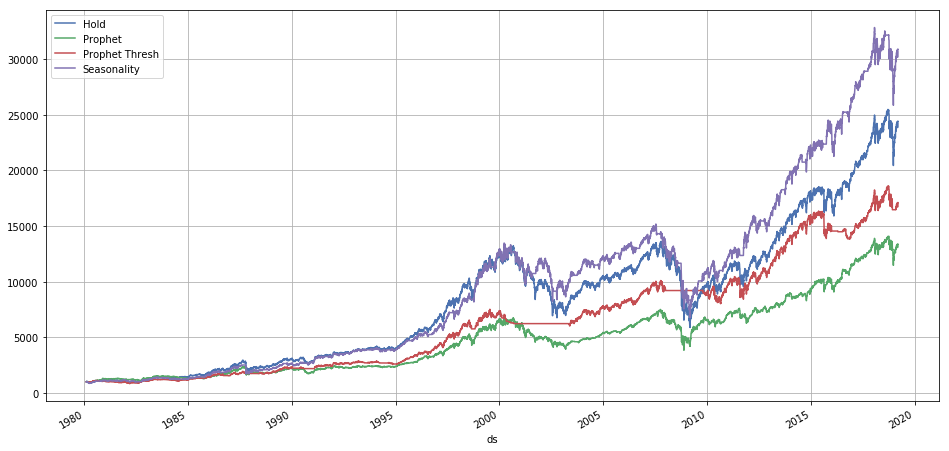

In [21]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh','Seasonality']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")

As a result of the previous code block, this code plots and prints the results of investment strategies.

First, the 'Hold', 'Prophet', 'Prophet Thresh', and 'Seasonality' columns are selected from the 'df' dataframe, any missing values are dropped, and the 'ds' column is set as the index column. To make these values easier to visualize, it multiplies them by 1000.

Using pandas' plot() method, the resulting dataframe is plotted with the figsize parameter set to (16,8) for a larger figure. Grids are added to plots by setting the grid parameter to True.

To scale up the investment strategy values, the second set of code uses the iloc[] method to select the last value in each column. The results are then printed with commas as thousands separators using formatted string literals (f-strings).

To show the total return of each investment strategy, this code plots their performance over time on a graph. To determine the most effective investment strategy for this stock, the investment strategies can be further analyzed and optimized.

The plot above shows the results of simulating an investment of $1,000. Seasonality performed best, followed by Hold as the benchmark strategy. We didn't do well with either Prophet-based strategy. Let's optimize the Prophet Thresh to see if it can be improved.

'Best Yhat = 0.92'

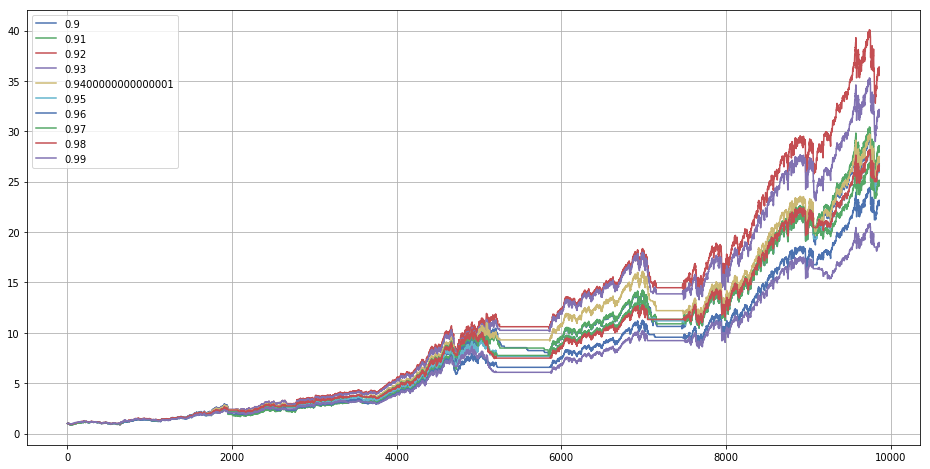

In [22]:
performance = {}

for x in np.linspace(.9,.99,10):
    y = ((df['y'] > df['yhat_lower']*x).shift(1)* (df['Percent Change']) + 1).cumprod()
    performance[x] = y
    
best_yhat = pd.DataFrame(performance).max().idxmax()
pd.DataFrame(performance).plot(figsize=(16,8), grid=True);
f'Best Yhat = {best_yhat:,.2f}'

By adjusting the value of 'yhat_lower', this code optimizes the Prophet model by adjusting the prediction interval width.

In the first line of code, an empty dictionary called 'performance' is created to store the performance of different values of 'yhat_lower'.

The for loop in the next three lines iterates through a list of 10 evenly spaced values between 0.9 and 0.99. For each value of x, it calculates a new investment strategy based on whether the actual stock prices were higher than the lower bound of the prediction intervals multiplied by x. The resulting investment strategy is then stored in the 'performance' dictionary with the value of x as the key.

Next, 'best_yhat' is created by selecting the maximum value from each column of the 'performance' dictionary using the max() method, and then returning the index value of the maximum value using the idxmax() method. The index value represented here represents the value of 'yhat_lower' that resulted in the highest return on investment.

An f-string is used to print the optimal value for 'yhat_lower' using the best_yhat dataframe as determined by the plot() method of pandas.

By testing different values of 'yhat_lower', this code optimizes the Prophet model by grid searching to identify the most optimal value. By retraining the Prophet model with 'yhat_lower', prediction accuracy can be improved.

Above we loop through various percents of the thresh to find the optimal thresh.  It appears the best threshhold is 92% of our current yhat_lower.

In [23]:
df['Optimized Prophet Thresh']  = ((df['y'] > df['yhat_lower'] * best_yhat).shift(1) * 
                                   (df['Percent Change']) + 1).cumprod()

Using the optimized value of 'yhat_lower' calculated in the previous code block, this code creates a new investment strategy column in the 'df' dataframe.


An optimized prophet threshold is added to the dataframe called 'df' by the line of code above. In this case, the cumulative product is calculated by multiplying the actual stock price with the optimal value of 'yhat_lower' plus the percentage change in the stock price. It uses the shift() method to shift the Boolean values in the expression '(df['y'] > df['yhat_lower'] * best_yhat)' by one row, so that each value represents whether the actual price was higher than the lower bound of the prediction for the previous time period using the optimal value of 'yhat_lower'. Taking the cumulative product requires multiplying the resulting Boolean values by the percentage change and adding 1.


A strategy based on the lower bound of the prediction interval is used to calculate investment returns using the optimized value of 'yhat_lower'. The new column can be used to analyze and compare the other investment strategies in the 'df' dataframe.

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Seasonality = 30,861
Optimized Prophet Thresh = 36,375


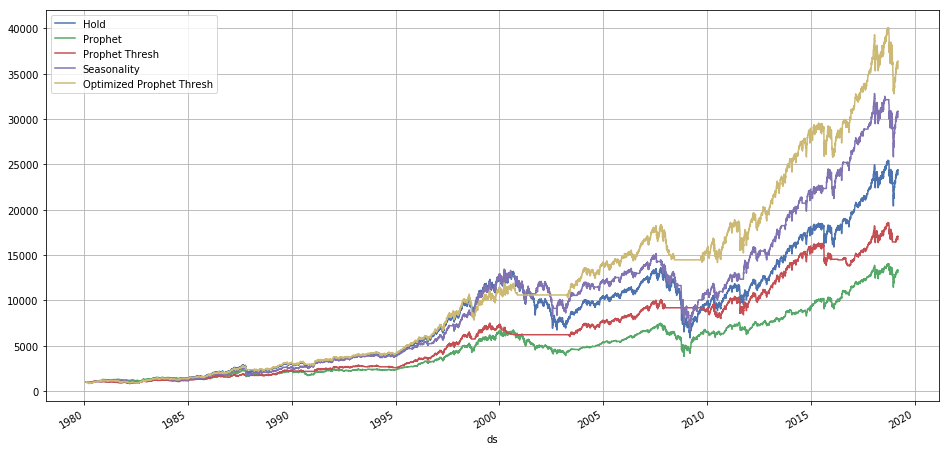

In [24]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Seasonality', 'Optimized Prophet Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Optimized Prophet Thresh = {df['Optimized Prophet Thresh'].iloc[-1]*1000:,.0f}")

In this code, the results of different investment strategies, including the optimized Prophet model, are plotted and printed.

From the 'df' dataframe, the first line selects the 'Hold', 'Prophet', 'Prophet Thresh', 'Seasonality', and 'Optimized Prophet Thresh' columns. The 'ds' column is used as the index. In order to make these values more visible, it multiplies them by 1000.

Using pandas' plot() method, the resulting dataframe is plotted with the figsize parameter set to (16,8) for a larger figure. Grids are added to plots by setting the grid parameter to True.

Using the iloc[] method, the second set of code selects the last value in each investment strategy column, and multiplies it by 1000 to scale it up. Using formatted string literals (f-strings), it prints the results separated by commas.

A graph is plotted to compare the performance of different investment strategies over time, and the final value of each strategy is printed to show their return. It is included in this comparison to see if the optimized Prophet model strategy outperforms the other strategies. Investment decisions can be made based on the results, and the investment strategy can be optimized.

Above, we see that our new "Optimized Prophet Thresh" is one of the best trading strategies.  Due to their reliance on data from the future that would not be available at the time of our trade, both Seasonaity and Optimized Prophet Thresh are cheating.  The Optimized Thresh will need to be created for every current point in our forecast.

In [25]:
fcst_thresh = {}

for num, index in enumerate(df['month/year_index'].unique()):

    temp_df = df.set_index('ds')[
         df[df['month/year_index'] == df['month/year_index'].unique()[0]]['ds'].min():\
         df[df['month/year_index'] == index]['ds'].max()]

    performance = {}
    
    for thresh in np.linspace(0, .99, 100):
        percent =  ((temp_df['y'] > temp_df['yhat_lower'] * thresh).shift(1)* (temp_df['Percent Change']) + 1).cumprod()
        performance[thresh] = percent
    
    best_thresh = pd.DataFrame(performance).max().idxmax()
    
    if num == len(df['month/year_index'].unique())-1:
        pass
    else:
        fcst_thresh[df['month/year_index'].unique()[num+1]] = best_thresh


By adjusting the prediction interval width ('yhat_lower') separately for each month of data, this code aims to improve the Prophet model's performance.

For each month of data, the first line creates an empty dictionary called 'fcst_thresh' that stores the optimal values of 'yhat_lower'.

In the next six lines, a for loop iterates through each month of data in the 'df' dataframe. It creates a temporary dataframe called 'temp_df' containing only the current month's data. The code calculates the investment return for different values of 'yhat_lower' and stores the results in a dictionary called 'performance', where the key is the value of 'yhat_lower' and the value is the investment return.

Using the max() method, the code creates a new dataframe called 'best_thresh', which returns the index value of the maximum value from each column of the 'performance' dictionary. This index value represents the optimal value for 'yhat_lower' that resulted in the highest investment return for the current month.

In the next conditional statement, we check if the current month is the last month in the 'df' dataframe. The loop does nothing if it is. Otherwise, it adds the next month's optimal value to the 'fcst_thresh' dictionary with yhat_lower as the key.

In general, this code estimates the optimal value of 'yhat_lower' for each month of data, thereby optimizing the Prophet model at a granular level. These values can be used to improve prediction accuracy and further optimize the investment strategy for this stock.

In [26]:
fcst_thresh = pd.DataFrame([fcst_thresh]).T.reset_index().rename(columns={'index':'month/year_index', 0:'Fcst Thresh'})

To get the optimal values of 'yhat_lower' for each month of data, this code creates a new dataframe called 'fcst_thresh'.

Using pd.DataFrame(), a new dataframe is created named 'fcst_thresh'. Transposing the resulting dataframe using the T attribute is performed based on the dictionary 'fcst_thresh' as input. Next, it renames the columns of the resulting dataframe using the rename() method, then resets the index of the dataframe using the reset_index() method.

Two columns are included in the dataframe: 'month/year_index' and 'Fcst Thresh'. From the original 'df' dataframe, the 'month/year_index' column represents the unique values for each month. According to the previous code block, the 'Fcst Thresh' column contains the optimal values of 'yhat_lower' for each month of data.

It summarizes each month's optimal 'yhat_lower' values into a new dataframe with a more structured format. The Prophet model and investment strategy for this stock can be further analyzed and optimized using this dataframe.

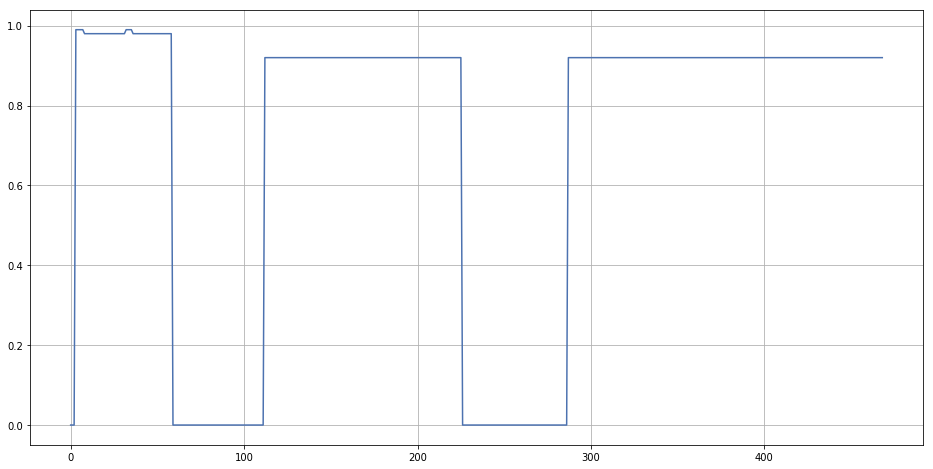

In [27]:
fcst_thresh['Fcst Thresh'].plot(figsize=(16,8), grid=True);

For each month of data in the 'fcst_thresh' dataframe, this code plots the optimal values of 'yhat_lower'.

The code selects the 'Fcst Thresh' column from the 'fcst_thresh' dataframe and then calls the plot() method on it. To create a larger figure, the figsize parameter is set to (16,8). To add a grid to the plot, set the grid parameter to True.

An x-axis plot shows the index values of the 'month/year_index' column, and the y-axis shows the optimal values of 'yhat_lower' for each month of data. Plotting the optimal values of 'yhat_lower' over time allows us to see trends and patterns in the optimal values over time, which can help us optimize the Prophet model and investment strategy for this stock.

Above, like how we created our monthly forecast, we loop through the data and find the optimal thresh percent period to date for that current point in time.  As you can see the % of the current thresh jumps around as we get further in to the periods (1/1/1980 - 3/18/2019).  

In [28]:
df['yhat_optimized'] = pd.merge(df, fcst_thresh, 
                                on='month/year_index', 
                                how='left')['Fcst Thresh'].shift(1) * df['yhat_lower']

To optimize the upper bound of prediction intervals for each time period, this code creates a column called 'yhat_optimized' in the 'df' dataframe.

Using pd.merge(), the 'df' and 'fcst_thresh' dataframes are merged on the 'month/year_index' column of the 'month/year_dataframe'. From the combined dataframe, the 'Fcst Thresh' column contains the optimized values of 'yhat_lower' for each month, from the 'fcst_thresh' dataframe.

As part of the merge operation, we use the 'left' join method, which keeps all the rows of the 'df' dataframe and adds the corresponding values of 'Fcst Thresh' from the 'fcst_thresh' dataframe where possible. In order to represent the optimized value of 'yhat_lower' for the previous time period, each value is shifted by one row with the shift() method.

To obtain the original lower bound of the prediction intervals, the resulting Series is multiplied by the 'yhat_lower' column of the 'df' dataframe. By scaling up the original lower bound by the optimized value of 'yhat_lower', the optimized upper bound of the prediction intervals is calculated.

After that, a column called 'yhat_optimized' is added to the 'df' dataframe to hold the resulting Series. The new column contains the optimized upper bound of the prediction intervals for each time period, which can be used for further analysis and comparison with the original Prophet model.

In [29]:
df['Prophet Fcst Thresh']  = ((df['y'] > df['yhat_optimized']).shift(1)* (df['Percent Change']) + 1).cumprod()

It uses the optimized upper bound of the prediction intervals ('yhat_optimized') to make investment decisions, and creates a column called 'Prophet Fcst Thresh' in the 'df' dataframe.

A bracket notation is used to select the 'y', 'yhat_optimized', and 'Percent Change' columns from the 'df' dataframe.

By calculating the investment return for a strategy that uses the optimized upper bound of the prediction intervals, a new column 'Prophet Fcst Thresh' is created in the 'df' dataframe. Similarly to the previous code blocks, it calculates the investment return by first shifting the Boolean values in the expression '(df['y'] > df['yhat_optimized'])' by one row, such that each value represents whether the actual price was higher than the upper bound of the prediction intervals for the previous period. Before taking the cumulative product, the resulting Boolean values are multiplied by the percentage change and added to 1.

Using the optimized upper bound of the prediction intervals, this code calculates the investment return for an investment strategy. In the 'df' dataframe, this new column can be used to analyze and compare investment strategies.

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Prophet Fcst Thresh = 20,620


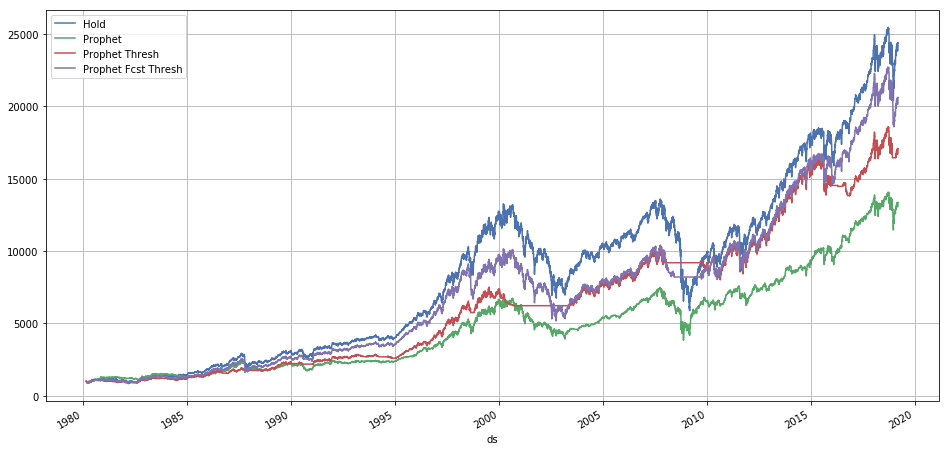

In [30]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Prophet Fcst Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
# print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Prophet Fcst Thresh = {df['Prophet Fcst Thresh'].iloc[-1]*1000:,.0f}")

Using the 'df' dataframe, this code prints out a line plot of investment returns for different investment strategies.

We start by selecting the columns 'Hold', 'Prophet', 'Prophet Thresh', and 'Prophet Fcst Thresh' from the 'df' dataframe using bracket notation. Following this, the dropna() method is used to remove any rows that contain missing values, and the set_index() method is used to set the index of the resulting dataframe to the 'ds' column. For the investment returns to be converted to dollars, the resulting dataframe is multiplied by 1000.

To create a larger figure size, the figsize parameter is set to (16,8), and the grid parameter is set to True to create a grid within the plot. As a result, a line plot depicts the investment returns over time for different investment strategies.

Using f-strings, the following four lines of code display the final investment returns. The final investment return for each investment strategy is calculated using the iloc() method, multiplied by 1000 to convert it from decimal to dollar form, and then formatted and printed with f-strings.

It provides a way of comparing the performance of different investment strategies over time by visualizing and summarizing their investment returns.

As we did before we create the new trading strategy and graph it.  Unfortunately are results have gotten worse but we did do better then our initial `Prophet Thresh`.  Instead of calculating the thresh using the full period to date let's try various rolling windows of time like you would see with a moving average(30, 60, 90, etc.).

In [31]:
rolling_thresh = {}

for num, index in enumerate(df['month/year_index'].unique()):
  
    rolling_performance = {}
    
    for roll in range(10, 400, 10):
            
        temp_df = df.set_index('ds')[
             df[df['month/year_index'] == index]['ds'].min() - pd.DateOffset(months=roll):\
             df[df['month/year_index'] == index]['ds'].max()]

        performance = {}
        
        for thresh in np.linspace(.0,.99, 100):
            percent =  ((temp_df['y'] > temp_df['yhat_lower'] * thresh).shift(1)* (temp_df['Percent Change']) + 1).cumprod()
            performance[thresh] = percent

        per_df =  pd.DataFrame(performance)
        best_thresh = per_df.iloc[[-1]].max().idxmax()
        percents = per_df[best_thresh]
        
        rolling_performance[best_thresh] = percents
    
    per_df =  pd.DataFrame(rolling_performance)
    best_rolling_thresh = per_df.iloc[[-1]].max().idxmax()
    
    if num == len(df['month/year_index'].unique())-1:
        pass
    else:
        rolling_thresh[df['month/year_index'].unique()[num+1]] = best_rolling_thresh

According to a rolling window approach, the rollng_thresh dictionary contains optimal values for 'yhat_lower' for every month of data.

A for loop is used to iterate through the unique values in the 'month/year_index' column of the 'df' dataframe. In order to store the results of the rolling window approach, it creates an empty dictionary called 'rolling_performance'.

After iterating through the loop, another for loop is used to iterate through the different rolling window sizes. By using the 'month/year_index' column and the 'pd.DateOffset()' method to shift the time index backwards by the specified rolling window size, the code selects the subset of the 'df' dataframe corresponding to the current month of data.

The code then calculates the investment returns for a range of threshold values using a similar process to the previous code blocks, by first shifting the Boolean values in the expression '(temp_df['y'] > temp_df['yhat_lower'] * thresh).shift(1)' by one row, so that each value represents whether the actual price was higher than the threshold value for the previous time period. Before taking the cumulative product, the Boolean values are multiplied by the percentage change and added to 1.

'Rolling_performance' stores the resulting investment returns, where the key is the optimal threshold value, and the value is the corresponding investment return.

It then creates a dataframe called 'per_df' that contains investment returns at each threshold value. Using the iloc() method, the final row of the dataframe is selected, the optimal threshold value is calculated by selecting the maximum value across all columns, and the resulting value is stored in the 'rolling_performance' dictionary.

The code creates another new dataframe called 'per_df' after the for loop has finished iterating over all rolling window sizes and contains the investment returns for each optimal threshold value. By selecting the maximum value across all columns, it calculates the optimal threshold value, and stores it in the 'rolling_thresh' dictionary by using the current month's data as the key.

For each month of data, this code optimizes the Prophet model and investment strategy using a rolling window approach, storing the optimal threshold values in a dictionary for analysis and comparison.

In [32]:
rolling_thresh = pd.DataFrame([rolling_thresh]).T.reset_index().rename(columns={'index':'month/year_index', 0:'Fcst Thresh'})

For further analysis and visualization, this line of code converts the 'rolling_thresh' dictionary into a dataframe.

By using the dictionary constructor, a new dictionary called 'rolling_thresh' is created and passed as a list. Using the T attribute, it transposes the resulting dictionary by swapping the rows and columns.

Using the reset_index() method, the code resets the index of the resulting dataframe, creating a new column called 'index' containing the unique values from the previous index column. This new column is renamed to 'month/year_index' using the rename() method, and the remaining column is renamed to 'Fcst Thresh' using the rename() method and passing a dictionary that maps the old column name to the new column name.

By combining the month/year index with the corresponding threshold value, this code creates a dataframe that contains optimal threshold values for each month of data. With the new dataframe, the rolling window approach can be further analyzed and visualized.

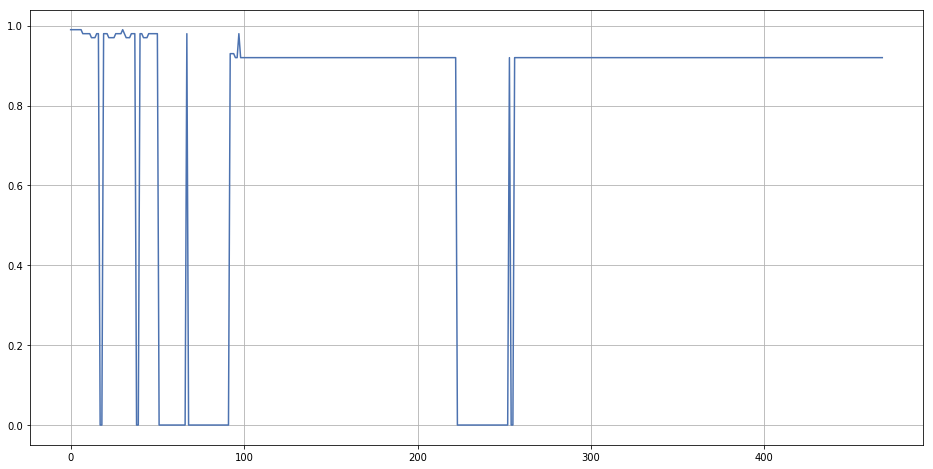

In [33]:
rolling_thresh['Fcst Thresh'].plot(figsize=(16,8), grid=True);

With the rolling window approach, this code creates a line plot of the optimal threshold values for each month of data.

Using bracket notation, the code selects the 'Fcst Thresh' column from the 'rolling_thresh' dataframe. The plot() method is then called on this column, with the figsize parameter set to (16,8) for a larger figure size, and the grid parameter set to True for a grid.

The resulting line plot shows the optimal thresholds for each month of data on the y-axis, and the corresponding month/year index on the x-axis. Visually comparing the optimal threshold values for each month of data, and assessing the effectiveness of the rolling window approach for optimizing the investment strategy for each month, can be achieved with this plot.

Above is very simliar to before but now we are trying out various moving windows along with various threshold percents.  This is getting quite complex.  No wonder Quants make so much money.  As you can see from above the thresh percents change over time.  Now let's see how we did.

In [34]:
df['yhat_optimized'] = pd.merge(df, rolling_thresh, 
                                on='month/year_index', 
                                how='left')['Fcst Thresh'].fillna(1).shift(1) * df['yhat_lower']

The purpose of this code is to create a new column called 'yhat_optimized' in the 'df' dataframe, which represents the Prophet model's predictions adjusted for the optimal threshold values obtained using the rolling window method.

The code begins by calling the merge() method on the 'df' dataframe and the 'rolling_thresh' dataframe, joining the two dataframes on the 'month/year_index' column with the 'on' parameter, and performing a left join using the 'how' parameter to make sure that all rows from the 'df' dataframe are included.

Each month's optimal threshold values are included in a new column named 'Fcst Thresh', which represents all columns in the 'df' dataframe. With a value of 1, the fillna() method fills in any missing values by applying a default threshold value of 1, and then shift() is used to move the values in this column one row upwards, so that the optimal threshold value for each time period applies to the predictions for the following time period.

The code then multiplies the adjusted threshold value by the 'yhat_lower' column of the 'df' dataframe and assigns the resulting values to the new 'yhat_optimized' column.

Overall, these lines of code adjust Prophet's predictions based on optimal threshold values obtained through the rolling window approach, and store the resulting predictions in a new column of the 'df' dataframe for further analysis.

In [35]:
df['Prophet Rolling Thresh']  = ((df['y'] > df['yhat_optimized']).shift(1)* (df['Percent Change']) + 1).cumprod()

According to this line of code, the 'df' dataframe will be updated to include a new column named 'Prophet Rolling Thresh' that represents the investment strategy's performance based on Prophet's predictions adjusted for optimal threshold values.

Using the shift(1) parameter, the code calls the shift() method on the 'y' and 'Percent Change' columns of the 'df' dataframe. As a result, the current row's performance is determined by the previous row's predictions and returns.

By using the '>' operator, the shifted 'Percent Change' column is multiplied by the shifted boolean values obtained by comparing the shifted 'y' column with the 'yhat_optimized' column of the 'df' dataframe. When the previous month's stock price exceeded the optimal threshold value, a new column is created containing 1 if it did not.

On this column of values, the cumprod() method calculates the cumulative product of the values, effectively compounding the returns over time. Using the rolling window approach, a new column of values is generated that represents the total return on investment over time.

For further analysis and visualization, these values are assigned to the 'Prophet Rolling Thresh' column of the 'df' dataframe.

Based on Prophet model predictions adjusted for optimal threshold values obtained through the rolling window method, this code calculates the total return on investment over time, and stores the results in a new column of the 'df' dataframe so that they can be analyzed and visualized further.

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Prophet Fcst Thresh = 20,620
Prophet Rolling Thresh = 23,621


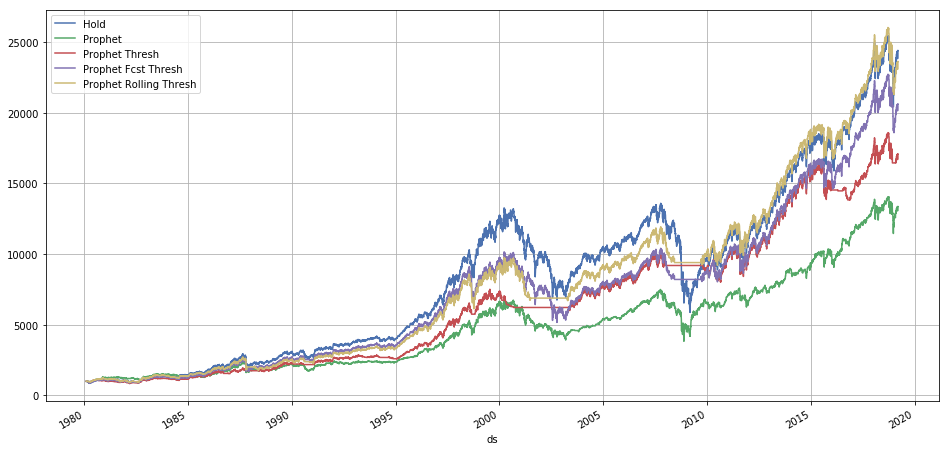

In [36]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Prophet Fcst Thresh', 'Prophet Rolling Thresh']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
# print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Prophet Fcst Thresh = {df['Prophet Fcst Thresh'].iloc[-1]*1000:,.0f}")
print(f"Prophet Rolling Thresh = {df['Prophet Rolling Thresh'].iloc[-1]*1000:,.0f}")

Using the 'plot()' method of the pandas dataframe, this code block visualizes the performance of investment strategies over time based on different threshold values.

By calling the 'dropna()' method on the 'df' dataframe, any rows with missing values are removed, and the 'set_index()' method is called to set the 'ds' column as the dataframe's index.

This code snippet selects the columns for the plot, and the '[[['Hold','Prophet','Prophet Thresh','Prophet Fcst Thresh','Prophet Rolling Thresh']]'' code snippet multiplies the values in these columns by 1000 to convert them into dollar values easier to interpret.

It is then plotted using the 'plot()' method, which creates a line plot of the selected columns over time, with the 'figsize' and 'grid' parameters setting the plot size and enabling gridlines.

After selecting the last row of the dataframe, the 'iloc[-1]' code snippet prints out the final values of each investment strategy using the f-string syntax. Each investment strategy's final dollar value is printed here.

The code block visualizes the performance of the investment strategies over time based on different threshold values and prints out the final dollar value for each investment strategy.

As you can see our new `Porphet Rolling Thresh` did pretty well but still did't beat out the simpliest `Hold` strategy.  Perhaps the saying "Time in the Market is better then Timing the Market" has some truth to it.

In [37]:
df['Time Traveler'] = ((df['y'].shift(-1) > df['yhat']).shift(1) * (df['Percent Change']) + 1).cumprod()

A new column called 'Time Traveler' will be created in the 'df' dataframe representing a hypothetical investment strategy based on future stock prices.

Using the shift(1) and shift(-1) parameters, the code first calls the shift() method on the 'y' and 'Percent Change' columns of the 'df' dataframe. As a result, the current row's performance is based on the stock price of the next month.

The code multiplies the shifted 'Percent Change' column with the shifted boolean values obtained by comparing the shifted 'y' column with the shifted 'yhat' column of the 'df' dataframe using the '>' operator. If the next month's stock price is greater than the current month's predicted stock price, we create a new column of values equal to the percentage change in returns.

This new column of values is then calculated using the cumprod() method, effectively compounding the returns over time. In this way, a new column of values is created that represents the total return on investment over time.

For further analysis and visualization, the code assigns these values to the 'Time Traveler' column of the 'df' dataframe.

For further analysis and visualization, this code calculates the total return on investment over time based on a hypothetical investment strategy that knows the future stock prices.

Hold = 24,396
Prophet = 13,366
Prophet Thresh = 17,087
Prophet Fcst Thresh = 20,620
Prophet Rolling Thresh = 23,621
Time Traveler = 288,513


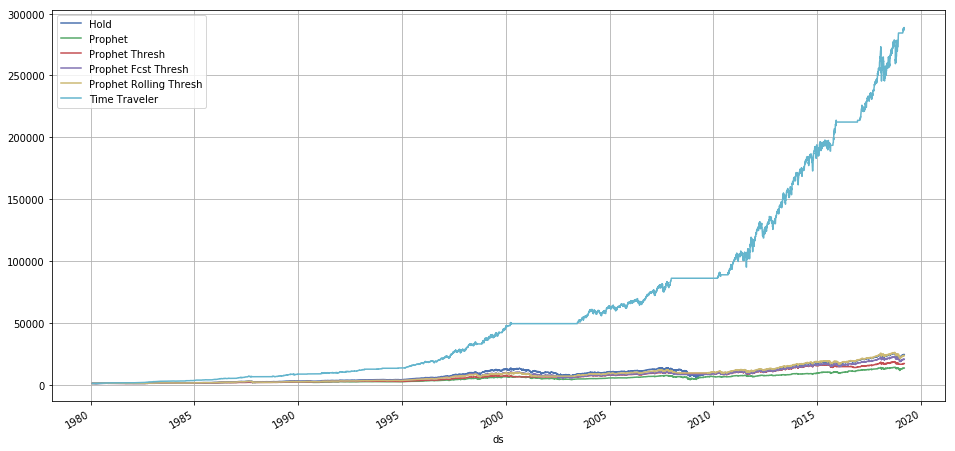

In [38]:
(df.dropna().set_index('ds')[['Hold', 'Prophet', 'Prophet Thresh',
                              'Prophet Fcst Thresh', 'Prophet Rolling Thresh',
                              'Time Traveler']] * 1000).plot(figsize=(16,8), grid=True)

print(f"Hold = {df['Hold'].iloc[-1]*1000:,.0f}")
print(f"Prophet = {df['Prophet'].iloc[-1]*1000:,.0f}")
print(f"Prophet Thresh = {df['Prophet Thresh'].iloc[-1]*1000:,.0f}")
# print(f"Seasonality = {df['Seasonality'].iloc[-1]*1000:,.0f}")
print(f"Prophet Fcst Thresh = {df['Prophet Fcst Thresh'].iloc[-1]*1000:,.0f}")
print(f"Prophet Rolling Thresh = {df['Prophet Rolling Thresh'].iloc[-1]*1000:,.0f}")
print(f"Time Traveler = {df['Time Traveler'].iloc[-1]*1000:,.0f}")

Using this code segment, you can plot the results of different investment strategies and print their final values.

Code in the first line sets the index of the 'df' dataframe to the 'ds' column and selects the desired columns ('Hold', 'Prophet', 'Prophet Thresh', 'Prophet Fcst Thresh', 'Prophet Rolling Thresh', and 'Time Traveler'). The values are then converted to dollars using the plot() method with a figsize of (16,8) and a grid.

Each investment strategy's final values are printed using f-strings in the following lines of code. To convert the values to dollars, the .iloc[-1] method selects the last row of each column in the 'df' dataframe. Results are printed to the console with labels indicating which strategy they belong to.

As a whole, this code segment displays the performance of each investment strategy and compares their final values.

Above I implemented my `Time Traveler` strategy. This of course would be a perfect trading strategy as I know in advance when the market moves up or down.  As you can the most you could make is $288,513 from $1,000. 

## Summary

Time Series Forecasting can be quite complex however Prophet makes it very easy to create robust forecasts with little effort.  While it didn't make us rich with its stock market predictions it is still very useful and can be implemented quickly to solve many use cases in various areas.